In [1]:
%pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [2]:
from datasets import load_dataset
import matplotlib.pyplot as plt

ds = load_dataset("PleIAs/French-PD-Books")

Resolving data files:   0%|          | 0/145 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/145 [00:00<?, ?it/s]

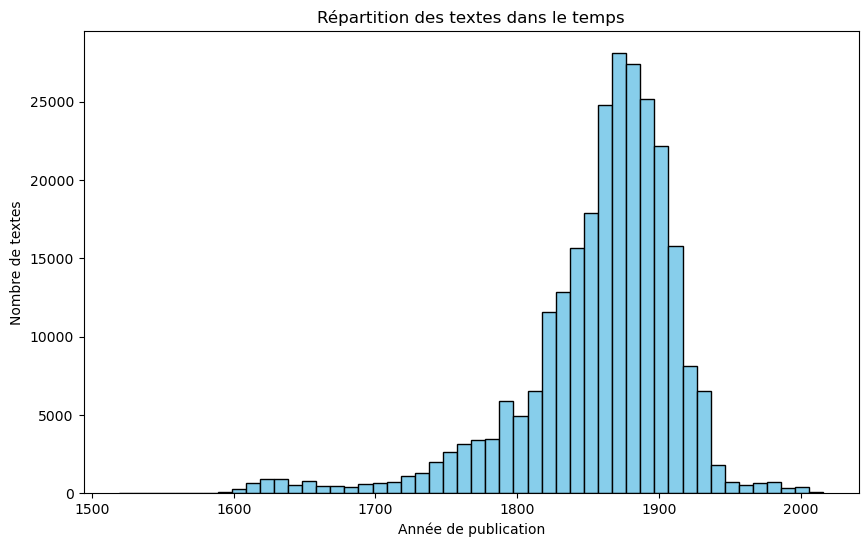

In [3]:
# Extraire les années de publication
years = ds['train']['date']

# Nettoyer et convertir en entiers (certaines dates peuvent être manquantes ou non numériques)
years_clean = [int(y) for y in years if str(y).isdigit()]

# Créer l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(years_clean, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Année de publication')
plt.ylabel('Nombre de textes')
plt.title('Répartition des textes dans le temps')
plt.show()

In [4]:
import re

def clean_text(example):
    text = example["complete_text"]
    date = example.get("date", None)

    # Si la date contient un "-", on essaie d'extraire l'année connue (format "1234-????" ou "????-1234") ou moyenne des deux années
    if "-" in str(date) and date is not None:
        parts = str(date).split("-")
        if (parts[1].isdigit() and len(parts[1]) == 4) and parts[0] == "????":
            date = str(parts[1])
        else:
            date = str(parts[0])

    # 1. Retirer les numéros de page
    text = re.sub(r"[—\-–]\s*\d+\s*[—\-–]", " ", text)
    
    # 2. Corriger les apostrophes et guillemets échappés
    text = text.replace("\\'", "'")
    text = text.replace("\\\"", "\"")
    text = text.replace("\\n", " ")
    text = text.replace("\\r", " ")
    text = text.replace("\\t", " ")
    
    # 3. Corriger les mots coupés (pattern plus précis)
    text = re.sub(r'([a-zàâäæçéèêëïîôùûüœ])\s+([a-zàâäæçéèêëïîôùûüœ]{2,})', 
                  r'\1\2', text)
    
    # 4. Corriger les cas avec plusieurs espaces
    text = re.sub(r'([a-zàâäæçéèêëïîôùûüœ])\s{2,}([a-zàâäæçéèêëïîôùûüœ])', 
                  r'\1\2', text)
    
    # 5. Normaliser les espaces multiples
    text = re.sub(r"\s+", " ", text)
    
    # 6. Nettoyer les caractères spéciaux
    text = re.sub(r"[^\w\s\.,;:\?!'\-\"«»À-ÖØ-öø-ÿœŒ]", " ", text)
    
    # 7. Re-normaliser après nettoyage
    text = re.sub(r"\s+", " ", text)
    
    # 8. Corriger la ponctuation
    text = re.sub(r"\s+([,.\?!;:])", r"\1", text)
    text = re.sub(r"([,.\?!;:])\s*([,.\?!;:])", r"\1\2", text)
    
    text = text.strip()
    return {"text": text, "date": str(date)}



In [5]:
example = ds['train'][500]

cleaned_example = clean_text(example)

def verify_clean_text(original_example, cleaned_example):
    # Vérifie que le texte nettoyé n'est pas vide
    if not cleaned_example["text"]:
        print("Le texte nettoyé est vide.")
        return False

    # Vérifie que la date est bien une année à 4 chiffres
    if not (cleaned_example["date"].isdigit() and len(cleaned_example["date"]) == 4):
        print(f"Date nettoyée incorrecte: {cleaned_example['date']}")
        return False

    # Vérifie que les caractères spéciaux indésirables ont été retirés
    if re.search(r"[^\w\s\.,;:\?!'\-\"«»À-ÖØ-öø-ÿœŒ]", cleaned_example["text"]):
        print("Caractères spéciaux indésirables présents dans le texte nettoyé.")
        return False

    # Vérifie qu'il n'y a pas de séquences d'espaces multiples
    if re.search(r"\s{2,}", cleaned_example["text"]):
        print("Espaces multiples détectés dans le texte nettoyé.")
        return False

    print("Le texte nettoyé semble correct.")
    return True

# Exemple d'utilisation
verify_clean_text(example, cleaned_example)

Le texte nettoyé semble correct.


True

In [6]:
reduced_ds = ds['train'].shuffle(seed=42).select(range(50000)) # Pour accélérer le traitement

cleaned_ds = reduced_ds.map(clean_text, remove_columns=reduced_ds.column_names)
# cleaned_ds = ds['train'].map(clean_text, remove_columns=ds['train'].column_names, num_proc=4)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [7]:
#for i in range(3):
#    print(f"\nExemple {i+1}:")
#    print(cleaned_ds[i])
#    print(cleaned_ds[i]["text"][:200])

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

# Créer les labels par tranches de 10 ans
def create_decade_label(example):
    """Crée une étiquette numérique (ex: 1880) pour chaque décennie."""
    year = int(example['date'])
    decade = (year // 10) * 10
    return {"decade": decade}

# Appliquer la fonction à votre dataset
dataset_with_labels = cleaned_ds.map(create_decade_label)

# Séparer en ensembles d'entraînement (80%) et de test (20%)
train_test_split = dataset_with_labels.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

# Extraire les textes et les labels pour une utilisation plus simple
train_texts = [ex['text'] for ex in train_dataset]
test_texts = [ex['text'] for ex in test_dataset]
train_labels = [ex['decade'] for ex in train_dataset]
test_labels = [ex['decade'] for ex in test_dataset]

print(f"Taille de l'ensemble d'entraînement : {len(train_texts)} textes.")
print(f"Taille de l'ensemble de test : {len(test_texts)} textes.")

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Taille de l'ensemble d'entraînement : 40000 textes.
Taille de l'ensemble de test : 10000 textes.


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
import gc

# Configuration du vectoriseur TF-IDF
# max_features limite la taille du vocabulaire pour économiser la mémoire
# min_df et max_df ignorent les mots trop rares ou trop fréquents
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    min_df=5,
    max_df=0.8,
    ngram_range=(1, 1) # On utilise uniquement des unigrammes (mots seuls)
)

print("Vectorisation TF-IDF en cours...")
X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
X_test_tfidf = tfidf_vectorizer.transform(test_texts)

# Libérer de la mémoire
del train_texts
del test_texts
gc.collect()

print(f"Shape des features TF-IDF (entraînement) : {X_train_tfidf.shape}")

Vectorisation TF-IDF en cours...
Shape des features TF-IDF (entraînement) : (40000, 10000)


In [21]:
%pip install sentence-transformers -q

from sentence_transformers import SentenceTransformer
import numpy as np
import random
import gc

def get_text_sample(text, selection_method="start_tokens", n_words=500):
    """
    Extrait un échantillon de texte en sélectionnant des mots (tokens)
    du début, du milieu, de la fin, et de manière aléatoire.
    """
    tokens = text.split()
    
    # Si le texte est trop court pour un échantillonnage significatif,
    # on retourne le texte entier.
    if len(tokens) < n_words * 4:
        return text

    if selection_method == "start_tokens":
        # 1. 500 mots du début
        sorted_tokens = tokens[:n_words]

    if selection_method == "end_tokens":
        # 2. 500 mots de la fin
        sorted_tokens = tokens[-n_words:]

    if selection_method == "middle_tokens":
        # 3. 500 mots du milieu
        middle_index = len(tokens) // 2
        middle_start = max(0, middle_index - (n_words // 2))
        sorted_tokens = tokens[middle_start : middle_start + n_words]

    if selection_method == "random_tokens":
        # 4. 500 mots aléatoires (en évitant les doublons avec les sections déjà extraites)
        # On construit la liste des indices déjà utilisés
        middle_index = len(tokens) // 2
        middle_start = max(0, middle_index - (n_words // 2))
        used_indices = set(range(n_words)) | set(range(len(tokens) - n_words, len(tokens))) | set(range(middle_start, middle_start + n_words))
        # On crée la liste des indices restants disponibles
        remaining_indices = [i for i in range(len(tokens)) if i not in used_indices]
        
        if len(remaining_indices) < n_words:
            random_indices = remaining_indices
        else:
            random_indices = random.sample(remaining_indices, n_words)
        
        sorted_tokens = [tokens[i] for i in sorted(random_indices)] # trier pour garder un semblant d'ordre

    return " ".join(sorted_tokens)

# Charger un modèle CamemBERT léger, spécialisé dans la création d'embeddings
embedding_model = SentenceTransformer('dangvantuan/sentence-camembert-base')

# Fonction pour créer les embeddings par lots (pour optimiser l'usage de la RAM)
def create_embeddings(texts, selection_method="start_tokens", batch_size=32):
    # Créer des échantillons de texte représentatifs
    sampled_texts = [get_text_sample(text, selection_method, n_words=500) for text in texts]
    
    print(f"Création des embeddings pour {len(sampled_texts)} textes...")
    return embedding_model.encode(
        sampled_texts,
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=True
    )

# Recréer les listes de textes car elles ont été supprimées
# Assurez-vous que les variables `train_dataset` et `test_dataset` sont bien définies en exécutant les cellules précédentes.
train_texts = [ex['text'] for ex in train_dataset]
test_texts = [ex['text'] for ex in test_dataset]

# start_tokens, end_tokens, middle_tokens, random_tokens
selection_method = "start_tokens"
X_train_embedding = create_embeddings(train_texts, selection_method, batch_size=16)
X_test_embedding = create_embeddings(test_texts, selection_method, batch_size=16)

print(f"Shape des embeddings (entraînement) : {X_train_embedding.shape}")

# Libérer de la mémoire
del train_texts
del test_texts
gc.collect()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.
Création des embeddings pour 40000 textes...


Batches:   0%|          | 0/2500 [00:00<?, ?it/s]

Création des embeddings pour 10000 textes...


Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Shape des embeddings (entraînement) : (40000, 768)


16

In [22]:
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, classification_report, accuracy_score
import numpy as np # Assurez-vous que numpy est importé

def train_with_loss_tracking(X_train, X_test, y_train, y_test, method_name, n_epochs=20):
    """
    Entraîne un classifieur SGD, suit la perte à chaque époque,
    et affiche les résultats ainsi qu'un graphique de la perte.
    """
    print(f"\\n{'='*50}")
    print(f"Entraînement avec suivi de la perte ({method_name})")
    print(f"{'='*50}\\n")

    classifier = SGDClassifier(
        loss='log_loss', 
        random_state=42, 
        n_jobs=-1, 
        #learning_rate='constant',
        #eta0=0.001
    )
    
    train_loss_history = []
    test_loss_history = []
    
    # --- CORRECTION 1 : Définir la liste complète de TOUS les labels ---
    # On combine les labels du train et du test pour être sûr de n'en oublier aucun.
    all_classes = np.unique(np.concatenate((y_train, y_test)))

    print(f"Début de l'entraînement pour {n_epochs} époques...")
    for epoch in range(n_epochs):
        classifier.partial_fit(X_train, y_train, classes=all_classes)
        
        y_train_pred_proba = classifier.predict_proba(X_train)
        y_test_pred_proba = classifier.predict_proba(X_test)
        
        # --- CORRECTION 2 : Passer `labels=all_classes` à log_loss ---
        train_loss = log_loss(y_train, y_train_pred_proba, labels=all_classes)
        test_loss = log_loss(y_test, y_test_pred_proba, labels=all_classes)
        
        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)
        
        print(f"Époque {epoch+1}/{n_epochs} - Perte entraînement: {train_loss:.4f} - Perte test: {test_loss:.4f}")

    # Visualisation de la fonction de perte
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label="Perte d'entraînement (Train Loss)")
    plt.plot(test_loss_history, label="Perte de validation (Test Loss)")
    plt.title(f"Évolution de la fonction de perte ({method_name})")
    plt.xlabel("Époques")
    plt.ylabel("Log Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Évaluation finale sur l'ensemble de test
    print("\\n------ ÉVALUATION FINALE ------")
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"🎯 Accuracy finale: {accuracy:.4f}\\n")
    print("📄 Rapport de classification détaillé :")
    print(classification_report(y_test, y_pred, zero_division=0)) # Ajout de zero_division pour éviter les warnings
    
    return classifier

\n==================================================
Entraînement avec suivi de la perte (Embeddings (CamemBERT))
==================================================\n
Début de l'entraînement pour 50 époques...
Époque 1/50 - Perte entraînement: 2.4359 - Perte test: 2.4721
Époque 2/50 - Perte entraînement: 2.4084 - Perte test: 2.4434
Époque 3/50 - Perte entraînement: 2.3990 - Perte test: 2.4334
Époque 4/50 - Perte entraînement: 2.3940 - Perte test: 2.4281
Époque 5/50 - Perte entraînement: 2.3907 - Perte test: 2.4247
Époque 6/50 - Perte entraînement: 2.3883 - Perte test: 2.4222
Époque 7/50 - Perte entraînement: 2.3865 - Perte test: 2.4204
Époque 8/50 - Perte entraînement: 2.3852 - Perte test: 2.4191
Époque 9/50 - Perte entraînement: 2.3841 - Perte test: 2.4180
Époque 10/50 - Perte entraînement: 2.3832 - Perte test: 2.4172
Époque 11/50 - Perte entraînement: 2.3826 - Perte test: 2.4165
Époque 12/50 - Perte entraînement: 2.3820 - Perte test: 2.4160
Époque 13/50 - Perte entraînement: 2.3815 -

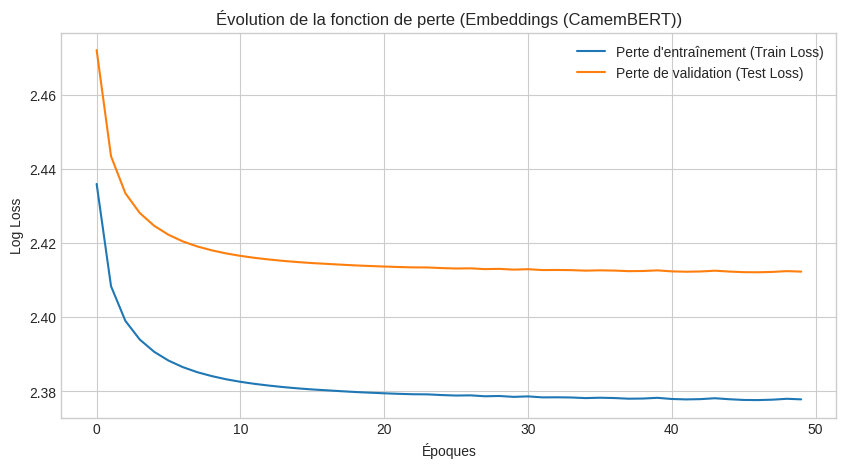

\n------ ÉVALUATION FINALE ------
🎯 Accuracy finale: 0.2550\n
📄 Rapport de classification détaillé :
              precision    recall  f1-score   support

        1560       0.00      0.00      0.00         1
        1570       0.00      0.00      0.00         2
        1580       0.00      0.00      0.00         2
        1590       0.00      0.00      0.00         1
        1600       0.00      0.00      0.00        12
        1610       0.00      0.00      0.00        27
        1620       0.00      0.00      0.00        24
        1630       0.20      0.04      0.07        23
        1640       0.00      0.00      0.00        27
        1650       0.00      0.00      0.00        27
        1660       0.00      0.00      0.00        12
        1670       0.00      0.00      0.00         7
        1680       0.00      0.00      0.00        10
        1690       0.00      0.00      0.00        25
        1700       0.00      0.00      0.00        21
        1710       0.00      0.00 

In [23]:
# Entraîner et évaluer avec TF-IDF et suivi de la perte
#model_tfidf_sgd = train_with_loss_tracking(
#    X_train_tfidf, X_test_tfidf, 
#    train_labels, test_labels,
#    "TF-IDF",
#    n_epochs=30
#)

# Entraîner et évaluer avec Embeddings et suivi de la perte
model_embedding_sgd = train_with_loss_tracking(
    X_train_embedding, X_test_embedding,
    train_labels, test_labels,
    "Embeddings (CamemBERT)",
    n_epochs=50
)

In [17]:
import random
import numpy as np

def predict_random_text(test_dataset):
    """
    Sélectionne un texte aléatoire dans le jeu de données, le prédit avec les deux modèles
    et affiche une comparaison.
    """
    # 1. Sélectionner un exemple aléatoire
    random_index = random.randint(0, len(test_dataset) - 1)
    random_example = test_dataset[random_index]
    
    title = random_example.get('title', 'Titre non disponible')
    true_date = random_example.get('date', 'Date non disponible')
    full_text = random_example.get('complete_text', '')

    print(f"--- Interrogation d'un texte aléatoire ---")
    print(f"📚 Titre : {title}")
    print(f"🗓️  Date réelle : {true_date}")
    print("-" * 40)

    # 2. Nettoyer le texte comme pour l'entraînement
    # La fonction clean_text renvoie un dictionnaire, nous extrayons le texte
    cleaned_text_dict = clean_text(random_example)
    cleaned_text = cleaned_text_dict['text']
    
    # Le texte doit être dans une liste pour les transformateurs
    text_to_predict = [cleaned_text]

    # 3. Prédiction avec le modèle TF-IDF
    #tfidf_features = tfidf_vectorizer.transform(text_to_predict)
    #prediction_tfidf = model_tfidf_sgd.predict(tfidf_features)[0]
    #print(f"🤖 Prédiction (TF-IDF) : {prediction_tfidf}s")

    # 4. Prédiction avec le modèle Embeddings
    embedding_features = create_embeddings(text_to_predict, batch_size=1)
    prediction_embedding = model_embedding_sgd.predict(embedding_features)[0]
    print(f"🧠 Prédiction (Embeddings) : {prediction_embedding}s")
    print(f"----------------------------------------\\n")

# --- Lancer le test ---
# Utilisez ds['test'] qui contient les métadonnées comme le titre.
predict_random_text(ds['train'])


--- Interrogation d'un texte aléatoire ---
📚 Titre : Les conserves de fruits pour la consommation familiale et pour la vente : la conservation des matières alimentaires dans les ménages, à la ferme et dans les coopératives agricoles
🗓️  Date réelle : 1912
----------------------------------------
🤖 Prédiction (TF-IDF) : 1900s
Création des embeddings pour 1 textes...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

🧠 Prédiction (Embeddings) : 1900s
----------------------------------------\n


--- Lancement de 20 essais de prédiction ---
Création des embeddings pour 1 textes...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Essai 1/20 | Réel : 1743 | Embeddings : 1820
Création des embeddings pour 1 textes...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Essai 2/20 | Réel : 1910 | Embeddings : 1870
Création des embeddings pour 1 textes...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Essai 3/20 | Réel : 1758 | Embeddings : 1860
Création des embeddings pour 1 textes...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Essai 4/20 | Réel : 1894 | Embeddings : 1860
Création des embeddings pour 1 textes...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Essai 5/20 | Réel : 1621 | Embeddings : 1770
Création des embeddings pour 1 textes...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Essai 6/20 | Réel : 1834 | Embeddings : 1860
Création des embeddings pour 1 textes...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Essai 7/20 | Réel : 1860 | Embeddings : 1860
Création des embeddings pour 1 textes...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Essai 8/20 | Réel : 1914 | Embeddings : 1860
Création des embeddings pour 1 textes...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Essai 9/20 | Réel : 1832 | Embeddings : 1860
Création des embeddings pour 1 textes...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Essai 10/20 | Réel : 1876 | Embeddings : 1860
Création des embeddings pour 1 textes...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Essai 11/20 | Réel : 1885 | Embeddings : 1860
Création des embeddings pour 1 textes...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Essai 12/20 | Réel : 1883 | Embeddings : 1860
Création des embeddings pour 1 textes...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Essai 13/20 | Réel : 1879 | Embeddings : 1880
Création des embeddings pour 1 textes...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Essai 14/20 | Réel : 1853 | Embeddings : 1860
Création des embeddings pour 1 textes...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Essai 15/20 | Réel : 1799 | Embeddings : 1840
Création des embeddings pour 1 textes...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Essai 16/20 | Réel : 1865 | Embeddings : 1860
Création des embeddings pour 1 textes...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Essai 17/20 | Réel : 1833 | Embeddings : 1860
Création des embeddings pour 1 textes...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Essai 18/20 | Réel : 1828 | Embeddings : 1860
Création des embeddings pour 1 textes...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Essai 19/20 | Réel : 1828 | Embeddings : 1870
Création des embeddings pour 1 textes...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Essai 20/20 | Réel : 1872 | Embeddings : 1890


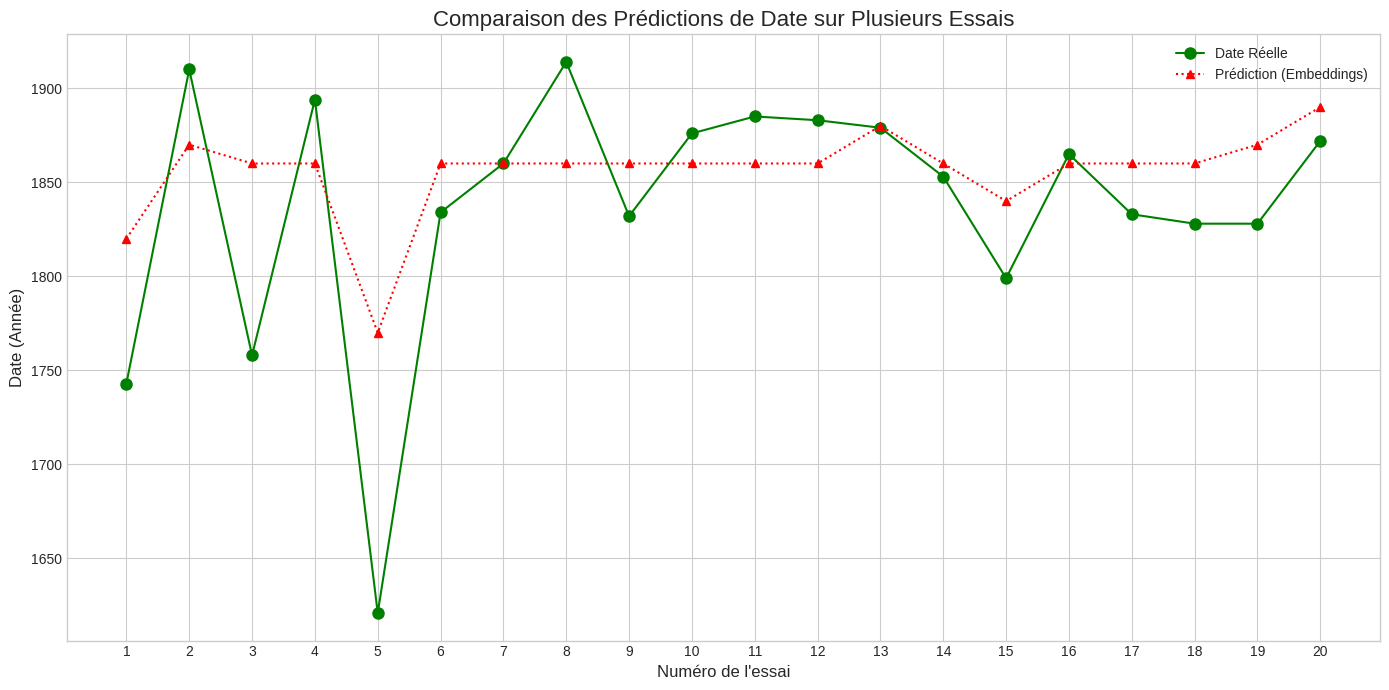

In [20]:
import random
import numpy as np
import matplotlib.pyplot as plt

def test_and_plot_predictions(test_dataset, num_trials=15):
    """
    Sélectionne plusieurs textes aléatoires, prédit leur date avec deux modèles,
    et affiche un graphique comparatif des résultats.
    
    Args:
        test_dataset (list): La liste d'exemples à tester.
        num_trials (int): Le nombre d'essais à effectuer.
    """
    real_dates = []
    tfidf_predictions = []
    embedding_predictions = []

    print(f"--- Lancement de {num_trials} essais de prédiction ---")

    for i in range(num_trials):
        # 1. Sélectionner un exemple aléatoire
        random_example = random.choice(test_dataset)
        
        # Extrait la date et la convertit en entier pour le graphique
        # On suppose que la date est au format 'YYYYs' (ex: '1990s')
        try:
            true_date_str = random_example.get('date', '0s')
            true_date_int = int(true_date_str[:4]) # Convertit '1990s' en 1990
        except (ValueError, IndexError):
            print(f"Avertissement : impossible de parser la date '{true_date_str}'. Essai ignoré.")
            continue

        # 2. Nettoyer le texte
        cleaned_text = clean_text(random_example)['text']
        text_to_predict = [cleaned_text]

        # 3. Prédiction avec le modèle TF-IDF
        #tfidf_features = tfidf_vectorizer.transform(text_to_predict)
        #prediction_tfidf = model_tfidf_sgd.predict(tfidf_features)[0]

        # 4. Prédiction avec le modèle Embeddings
        embedding_features = create_embeddings(text_to_predict, batch_size=1)
        prediction_embedding = model_embedding_sgd.predict(embedding_features)[0]
        
        # 5. Stocker les résultats
        real_dates.append(true_date_int)
        #tfidf_predictions.append(prediction_tfidf)
        embedding_predictions.append(prediction_embedding)
        
        #print(f"Essai {i+1}/{num_trials} | Réel : {true_date_int} | TF-IDF : {prediction_tfidf} | Embeddings : {prediction_embedding}")
        print(f"Essai {i+1}/{num_trials} | Réel : {true_date_int} | Embeddings : {prediction_embedding}")

    # 6. Générer le graphique
    if not real_dates:
        print("Aucune donnée à afficher.")
        return

    trials = range(1, len(real_dates) + 1)
    
    plt.style.use('seaborn-v0_8-whitegrid') # Style visuel agréable
    plt.figure(figsize=(14, 7)) # Taille de la figure

    # Tracer chaque série de données
    plt.plot(trials, real_dates, 'o-', color='green', label='Date Réelle', markersize=8)
    #plt.plot(trials, tfidf_predictions, 's--', color='blue', label='Prédiction (TF-IDF)')
    plt.plot(trials, embedding_predictions, '^:', color='red', label='Prédiction (Embeddings)')

    # Ajouter les titres et les légendes
    plt.title('Comparaison des Prédictions de Date sur Plusieurs Essais', fontsize=16)
    plt.xlabel("Numéro de l'essai", fontsize=12)
    plt.ylabel("Date (Année)", fontsize=12)
    plt.xticks(trials) # Assure que chaque essai a une graduation sur l'axe X
    plt.legend(fontsize=10)
    plt.tight_layout() # Ajuste le graphique pour qu'il s'affiche bien

    # Afficher le graphique
    plt.show()


# --- Lancer le test ---
# Utilisez ds['train'] et spécifiez le nombre d'essais souhaités (ex: 20)
test_and_plot_predictions(ds['train'], num_trials=20)